# Deliverable 1

### Univariate

In [2]:
#Import
import pandas as pd
import numpy as np
from numpy import exp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2_contingency, boxcox
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score, roc_curve
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn import svm
from scipy import stats




#Upload data
bank_df = pd.read_csv('bank-full.csv')

In [3]:
#Sanity Check of Data Types
def Sanity_Check(data):
        dtype = data.dtypes
        null = data.isnull().sum()
        unique = data.nunique()
        
        data_conc = pd.concat([dtype,null,unique], axis=1)
        data_conc.columns = ['dtype','null','unique']
        data_conc['%Null'] = data_conc['null'].values/len(data)
        
        return data_conc
Sanity_Check(bank_df)

# No Null Values observed

,dtype,null,unique,%Null
age,int64,0,77,0.0
job,object,0,12,0.0
marital,object,0,3,0.0
education,object,0,4,0.0
default,object,0,2,0.0
balance,int64,0,7168,0.0
housing,object,0,2,0.0
loan,object,0,2,0.0
contact,object,0,3,0.0
day,int64,0,31,0.0


In [4]:
#Check Skewness and other statistical details on Continuous Variable
#- Description
univariate_bank_df = pd.concat([bank_df.describe().T,bank_df.skew()],axis=1).rename(columns = {0:'Skewness'})
univariate_bank_df['Range']=univariate_bank_df['max']-univariate_bank_df['min']
univariate_bank_df #Shows continuous variables are all either slight[close to normal] or very right tailed. 

,count,mean,std,min,25%,50%,75%,max,Skewness,Range
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0,0.684818,77.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0,8.360308,110146.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0,0.093079,30.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0,3.144318,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0,4.898650,62.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0,2.615715,872.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0,41.846454,275.0


In [5]:
#Balance is negative. Might have placed wrongly but I will not take chance in guessing for balance due to having large enough dataset
bank_df = bank_df.loc[bank_df['balance']>=0]

,Subscription?,%
0,no,87.745204
1,yes,12.254796


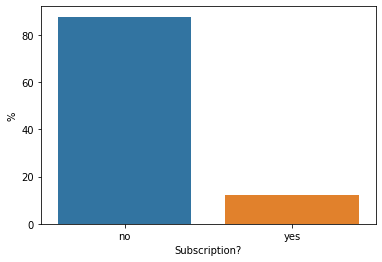

In [6]:
#Univariate on Target feature
target = 'Target'
target_df = bank_df[target].value_counts(normalize=True).reset_index().rename(columns={'index':'Subscription?','Target':'%'})
target_df['%'] = target_df['%']*100
target_plot = sns.barplot(x='Subscription?',y='%',data = target_df)
target_df 
#Shows % of 'Yes' subscription is only about 12% of population

In [7]:
print(bank_df[target].value_counts(normalize=True))
bank_df.shape 

no     0.877452
yes    0.122548
Name: Target, dtype: float64


(41445, 17)

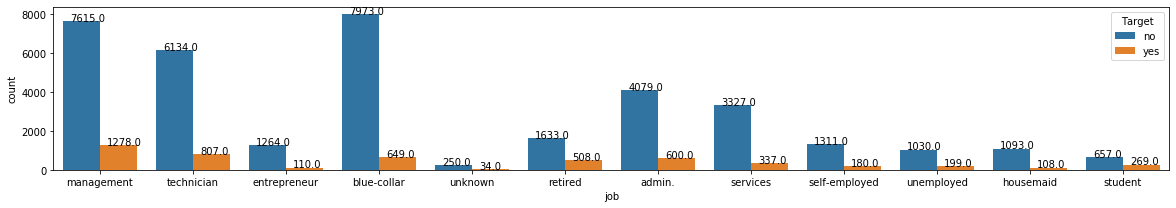

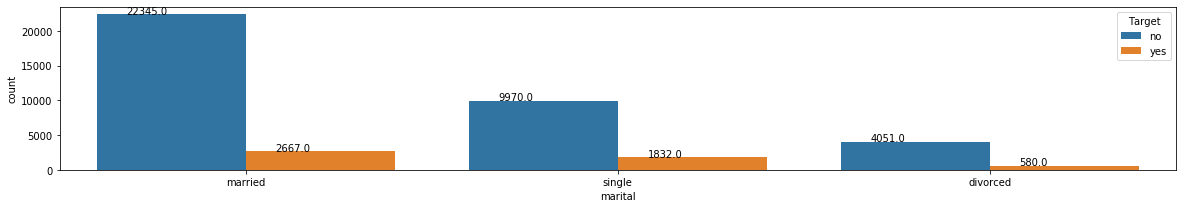

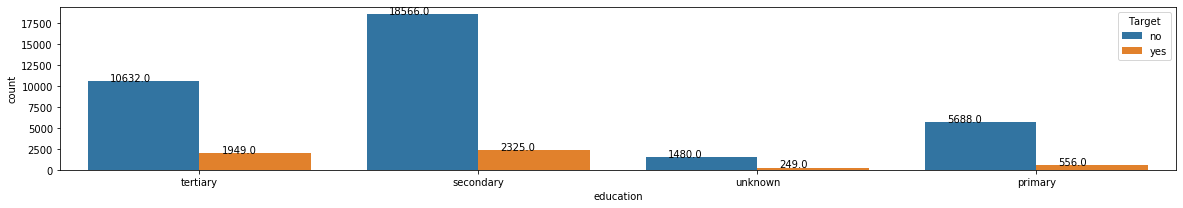

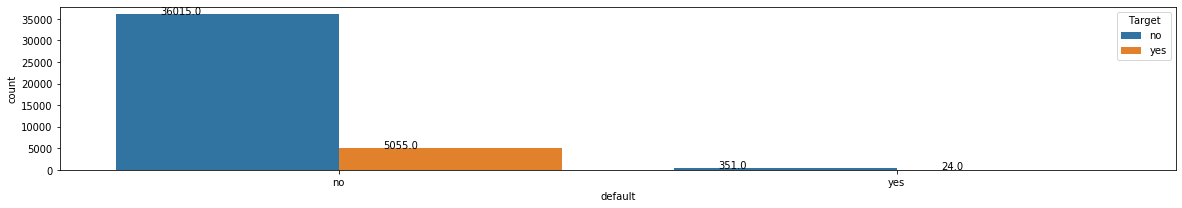

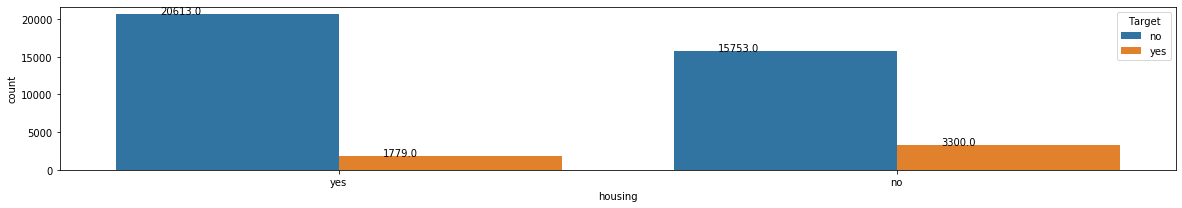

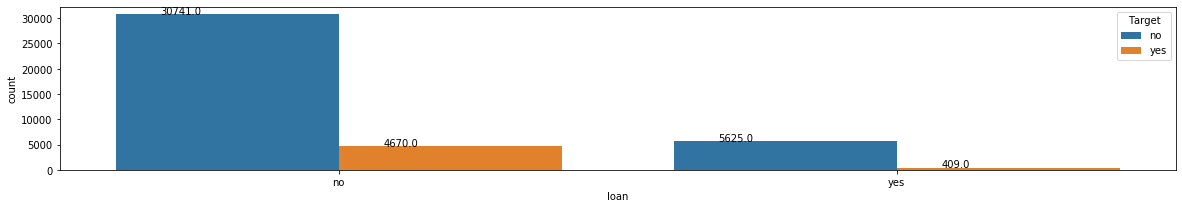

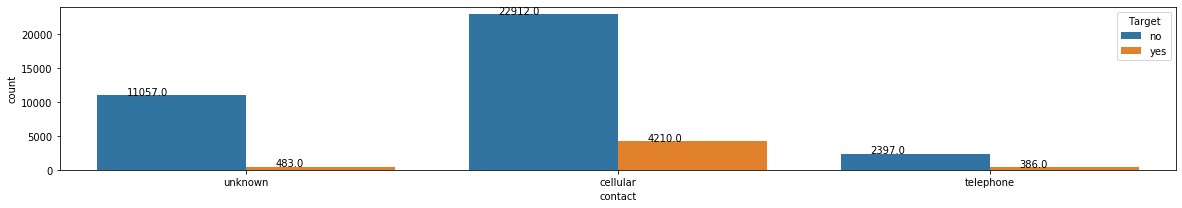

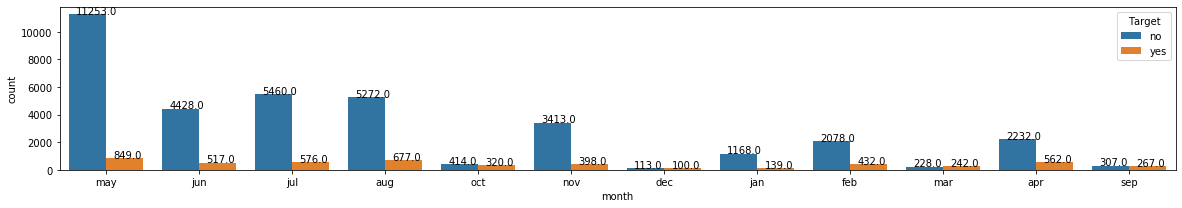

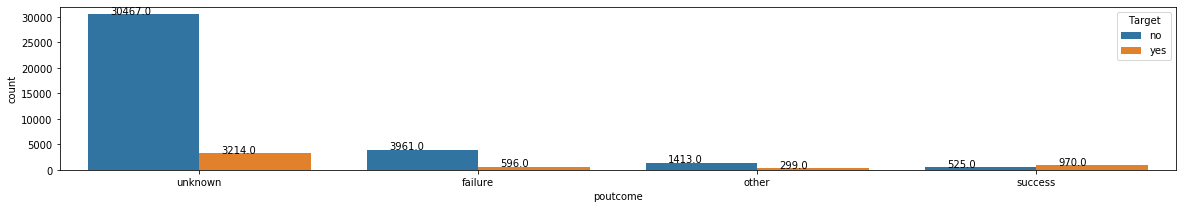

In [8]:
#Check if there is any weird value in any OBJECT feature without target in Percentage
cat_bank_df = bank_df.dtypes.reset_index().rename(columns = {0:'dtype','index':'cat_features'})
cat_bank_df = cat_bank_df.loc[cat_bank_df['dtype']=='object']
cat_features = cat_bank_df['cat_features'][:-1].tolist()
cat_norm_bank_df = bank_df.copy()



for x in cat_features:
    fig, axs = plt.subplots(figsize= (20,3))
    cat_plot = sns.countplot(x=x,data=cat_norm_bank_df,hue=bank_df['Target'])
    for p in cat_plot.patches:
        percentage = '{:.1f}'.format(p.get_height())
        x = p.get_x()+p.get_width()/5
        y = p.get_height()+10
        cat_plot.annotate(percentage,(x,y))
    plt.show()
#successful poutcome has high Yes to No subscription ratio
#seasonal also shows that March, Sept, Oct shows higher Yes to No subscription ratio
#More were successfully Subscribed through cellular phone
#Higher samples for higher income jobs

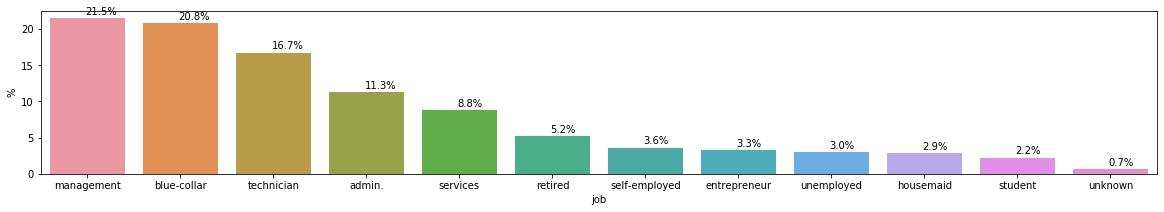

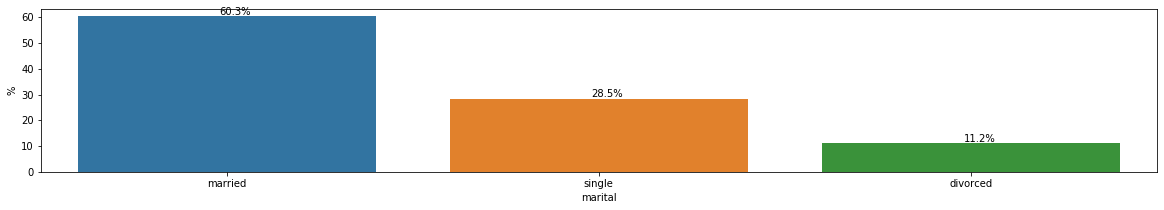

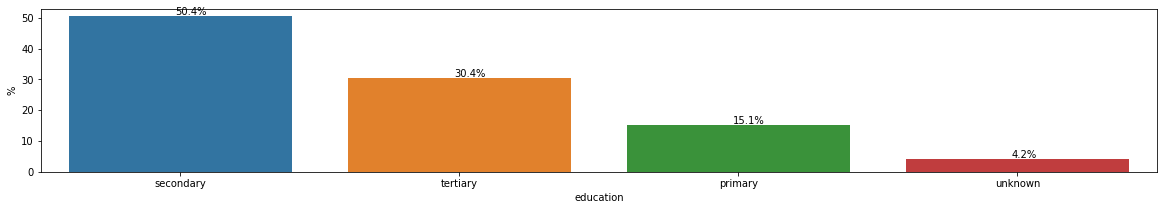

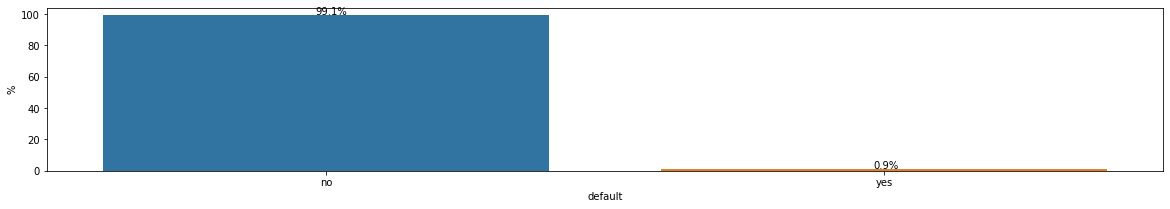

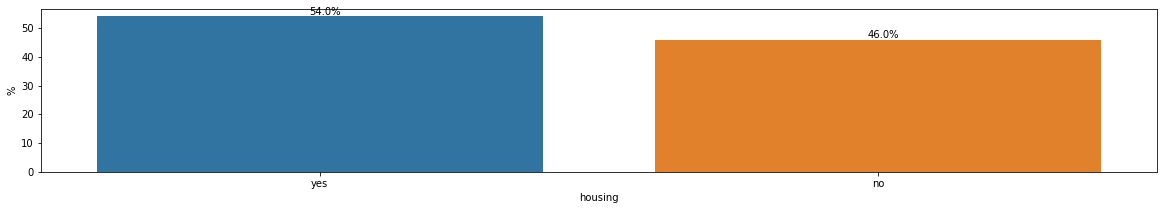

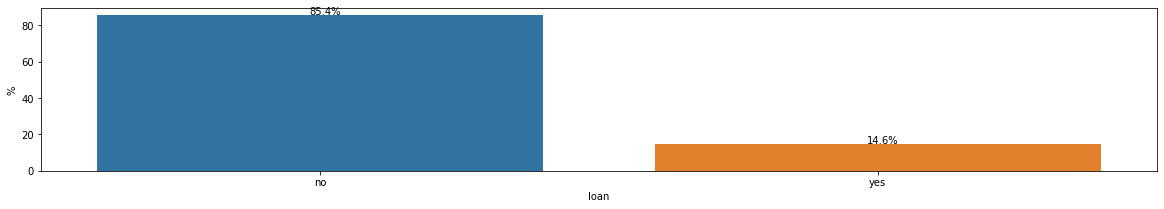

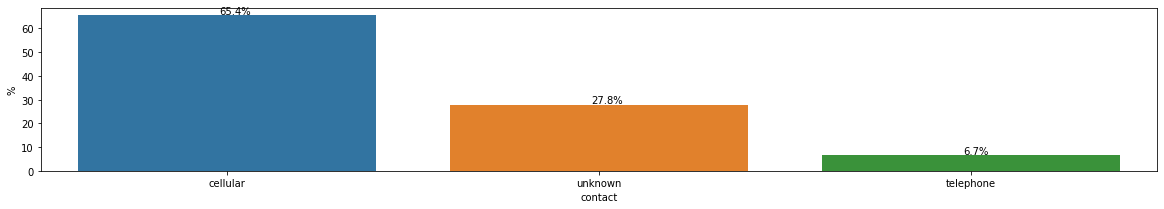

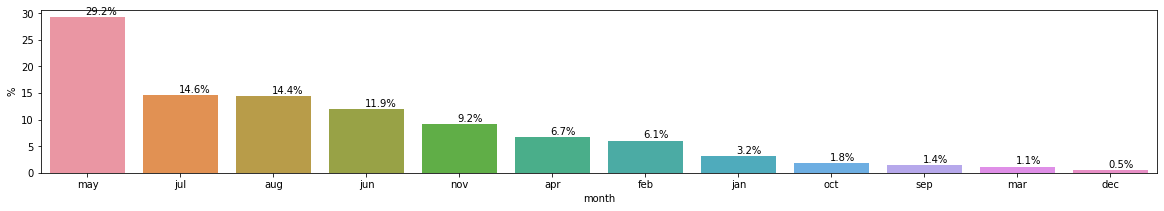

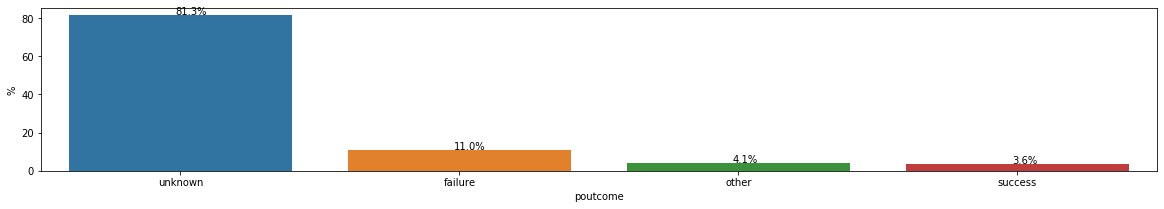

In [9]:
#Normalized % Univariate
for n in cat_features:
    fig, axs = plt.subplots(figsize= (20,3))
    cat_target_df = bank_df[n].value_counts(normalize=True).reset_index().rename(columns={'index':n,n:'%'})
    cat_target_df['%'] = cat_target_df['%']*100
    norm_cat_plot = sns.barplot(x=n,y='%',data = cat_target_df)
    for p in norm_cat_plot.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        x = p.get_x()+p.get_width()/2.1
        y = p.get_height()+0.5
        norm_cat_plot.annotate(percentage,(x,y))
    plt.show()
#Shows percentage of each unique values within population
#Most samples are 'Married', 'Secondary', 'No' on default and loan, 'cellular', 'May' season, and 'Unknown' poutcome

No Abnormal Cat values found

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


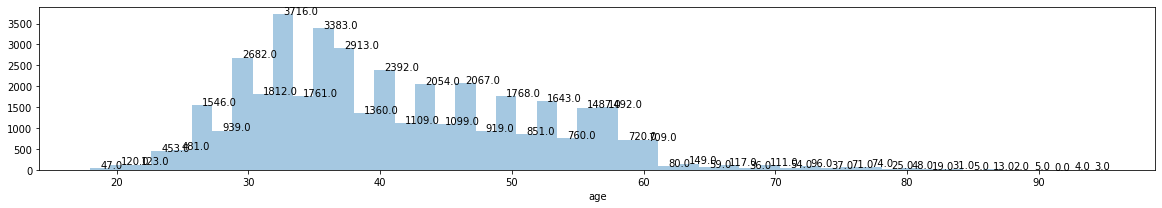

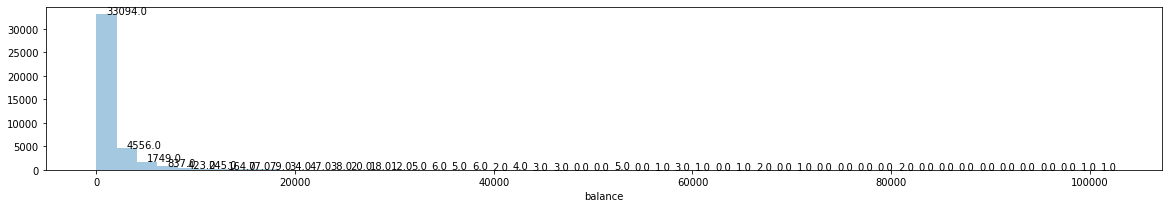

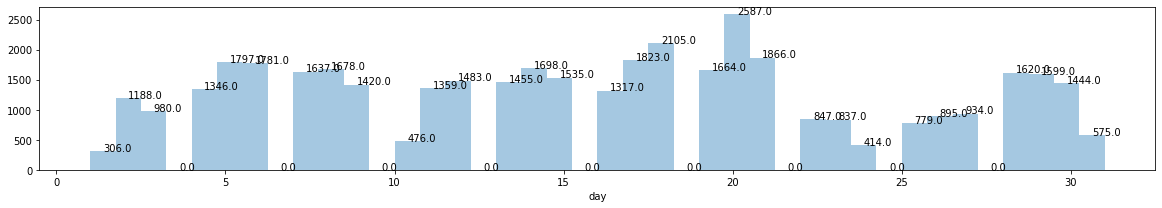

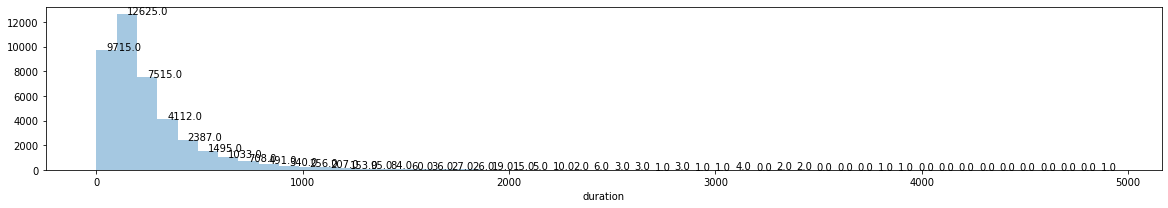

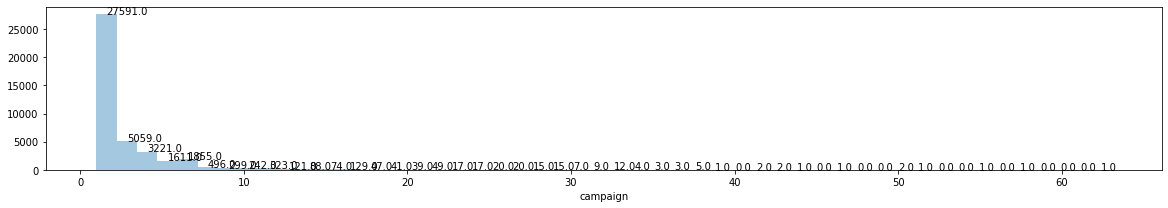

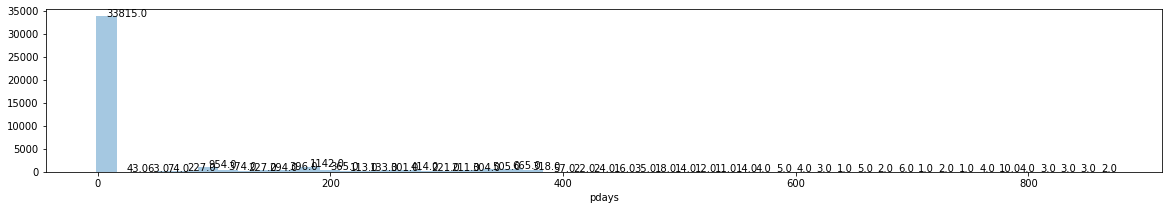

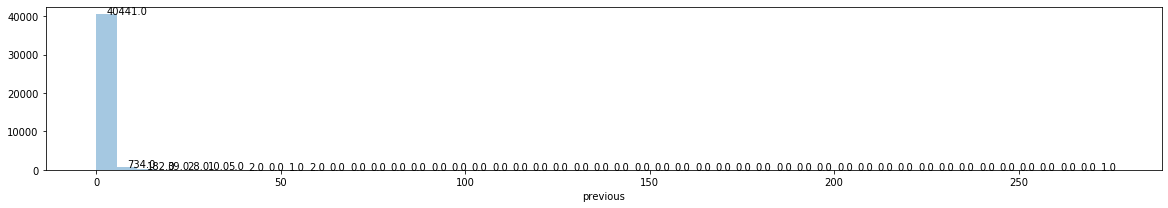

In [10]:
#Check if there is any weird value in any Continuous feature [Outlier detection and normal Plot]
cont_bank_df = bank_df.dtypes.reset_index().rename(columns = {0:'dtype','index':'cont_features'})
cont_bank_df = cont_bank_df.loc[cont_bank_df['dtype']!='object']
cont_features = cont_bank_df['cont_features'].tolist()
cont_norm_bank_df = bank_df.copy()
print(cont_features)
for c in cont_features:
    fig, axs = plt.subplots(figsize= (20,3))
    cont_plot = sns.distplot(cont_norm_bank_df[c],kde=False)
    for p in cont_plot.patches:
        percentage = '{:.1f}'.format(p.get_height())
        x = p.get_x()+p.get_width()/2
        y = p.get_height()+0.5
        cont_plot.annotate(percentage,(x,y))
    plt.show()

Balance, Duration, Campaign, Pdays, Previous Features are highly Skewed. Check for outliers

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


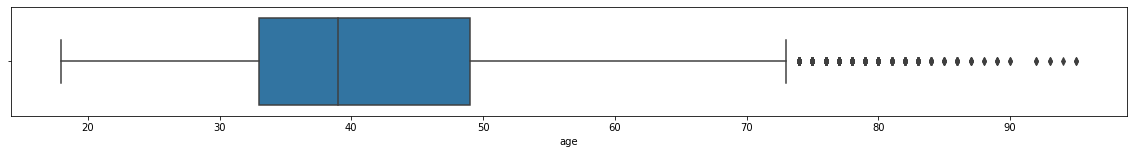

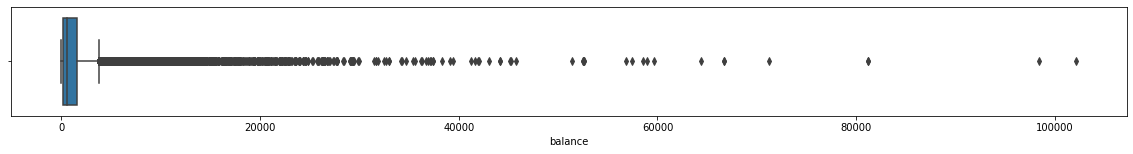

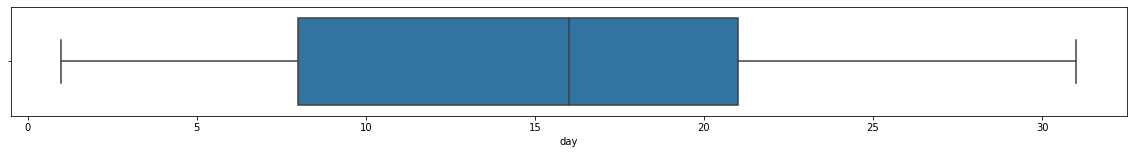

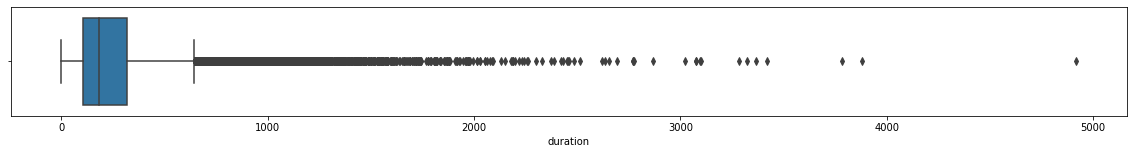

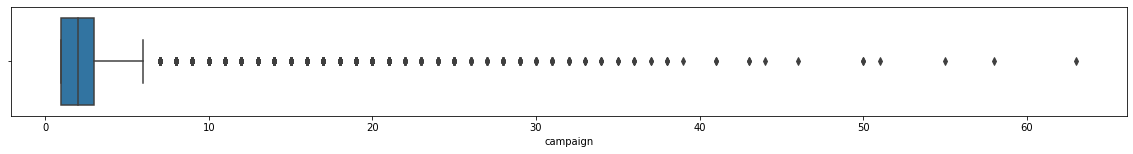

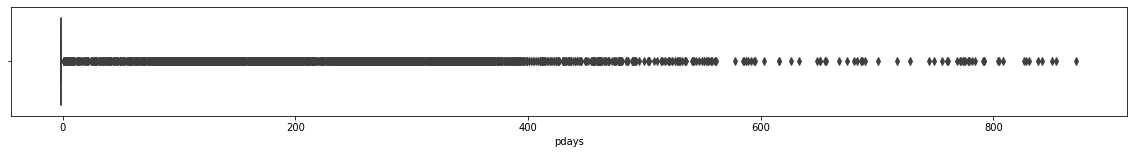

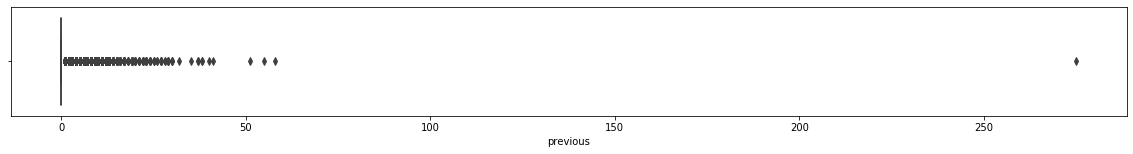

In [11]:
#Check if there is any weird value in any Continuous feature [Outlier detection and normal Plot] 2
print(cont_features)
for o in cont_features:
    fig, axs = plt.subplots(figsize= (20,2))
    cont_plot = sns.boxplot(x=cont_norm_bank_df[o])
    plt.show()

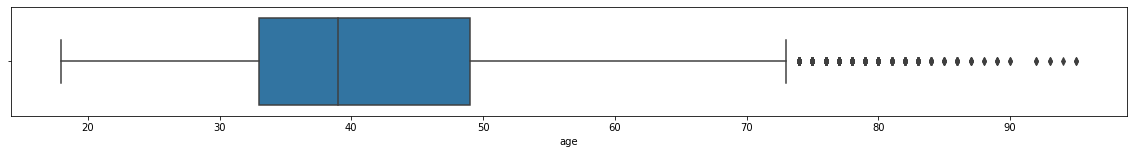

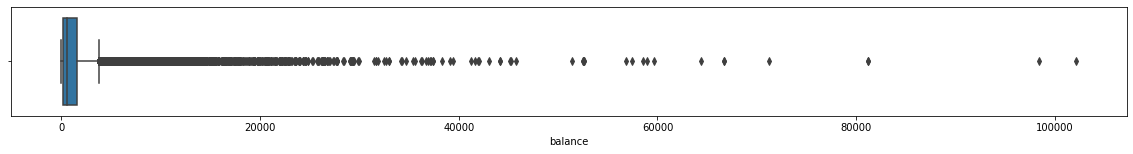

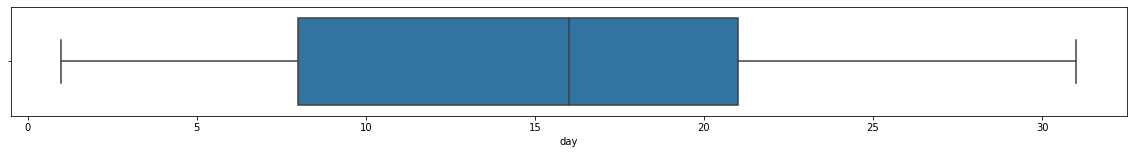

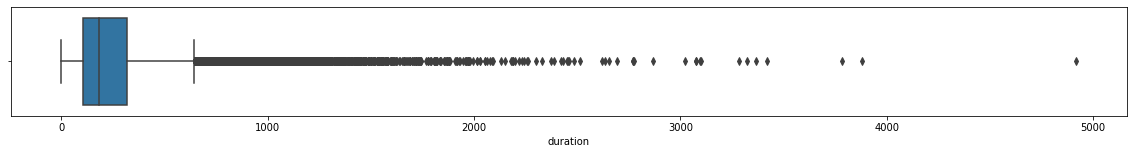

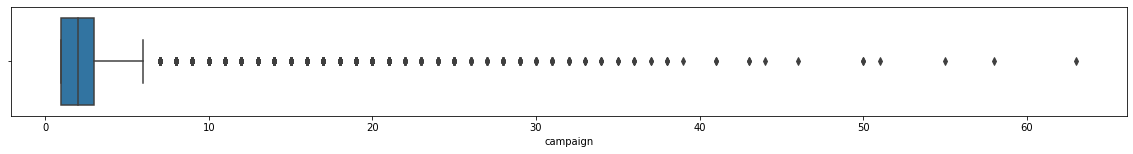

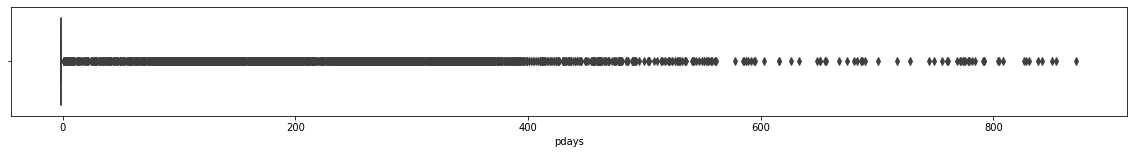

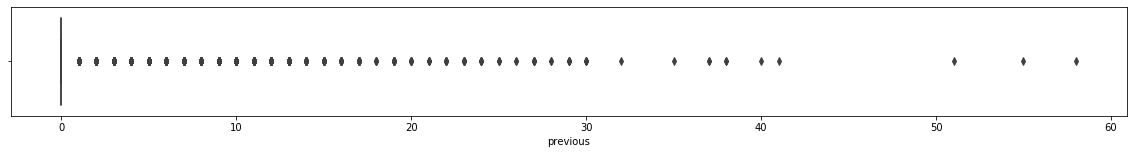

In [12]:
#Removing Out lier on Previous and redraw
previous_remove = cont_norm_bank_df.loc[cont_norm_bank_df['previous']<200]
for p in cont_features:
    fig, axs = plt.subplots(figsize= (20,2))
    cont_plot = sns.boxplot(x=previous_remove[p])
    plt.show()

In [13]:
#for pdays, there are too many samples with -1 value. Need to categorize pdays
print(previous_remove[previous_remove['pdays']<0]['pdays'].value_counts()/bank_df.shape[0]*100)
print('81% of dataset has pdays of -1')

#Will going to put them to two group categorical values.
# 1) Change feature name 'pdays' to 'Contacted_in_900D'
# 2) Any values above and below 900 will have 0 and 1, respectively

pdays_cat = previous_remove.copy()
pdays_cat.head()
pdays_cat = pdays_cat.rename(columns={'pdays':'Contacted_in_900D'})
pdays_cat.loc[(pdays_cat['Contacted_in_900D'] < 900)&(pdays_cat['Contacted_in_900D'] > -1), 'Contacted_in_900D'] = 1
pdays_cat = pdays_cat.replace({'Contacted_in_900D':{-1:0}})
print('\nNew pdays values with new feature name:\n',pdays_cat['Contacted_in_900D'].value_counts(),'\n\n')
# Now values for pdays only contain 0,1 with feature name change to Contacted_in_900D
pdays_cat.head()

-1    81.254675
Name: pdays, dtype: float64
81% of dataset has pdays of -1

New pdays values with new feature name:
 0    33676
1     7768
Name: Contacted_in_900D, dtype: int64 




,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,Contacted_in_900D,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0,0,unknown,no


In [14]:
#First Modified Bank dataset
mod_bank_df = pdays_cat.copy()

### Multivariate

In [15]:
#Multivariate Categorical variables with Statistical Analysis
#Crosstab across all categorical variable to Target cat variable
mod_bank_df['Contacted_in_900D'] = mod_bank_df['Contacted_in_900D'].astype(str)
cat_mod_bank_df = mod_bank_df.dtypes.reset_index().rename(columns = {0:'dtype','index':'cat_features'})
cat_mod_bank_df = cat_mod_bank_df.loc[cat_mod_bank_df['dtype']=='object']
cat_mod_features = cat_mod_bank_df['cat_features'][:-1].tolist()
print(cat_mod_features)

target = 'Target'
for i in cat_mod_features:
    df_crosstab = pd.crosstab(mod_bank_df[i],mod_bank_df[target],margins=False,normalize='index')
    stat, p, dof, expected = chi2_contingency(df_crosstab)
    
    print(df_crosstab,'\n')
    print('feature: ',i,'\nstat: ', stat,'\np-value: ', p,'\ndof: ', dof, '\nexpected: \n',expected, end='\n\n------------------------------\n\n')

#Shows Yes percentage by each feature unique values

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'Contacted_in_900D', 'poutcome']
Target               no       yes
job                              
admin.         0.871767  0.128233
blue-collar    0.924727  0.075273
entrepreneur   0.919942  0.080058
housemaid      0.910075  0.089925
management     0.856275  0.143725
retired        0.762728  0.237272
self-employed  0.879276  0.120724
services       0.908024  0.091976
student        0.709503  0.290497
technician     0.883734  0.116266
unemployed     0.838080  0.161920
unknown        0.880282  0.119718 

feature:  job 
stat:  0.3921350046665576 
p-value:  0.9999996223347692 
dof:  11 
expected: 
 [[0.86203444 0.13796556]
 [0.86203444 0.13796556]
 [0.86203444 0.13796556]
 [0.86203444 0.13796556]
 [0.86203444 0.13796556]
 [0.86203444 0.13796556]
 [0.86203444 0.13796556]
 [0.86203444 0.13796556]
 [0.86203444 0.13796556]
 [0.86203444 0.13796556]
 [0.86203444 0.13796556]
 [0.86203444 0.13796556]]

-----------

High p-value tells that there isn't significant impact to "Target" decision

Low p-value features are: default, housing, loan, Contacted_in_900D

December, March, and Success have the highest Subscription Target Percentage. 
Also, Target contacted in 900Days has higher change of subscription

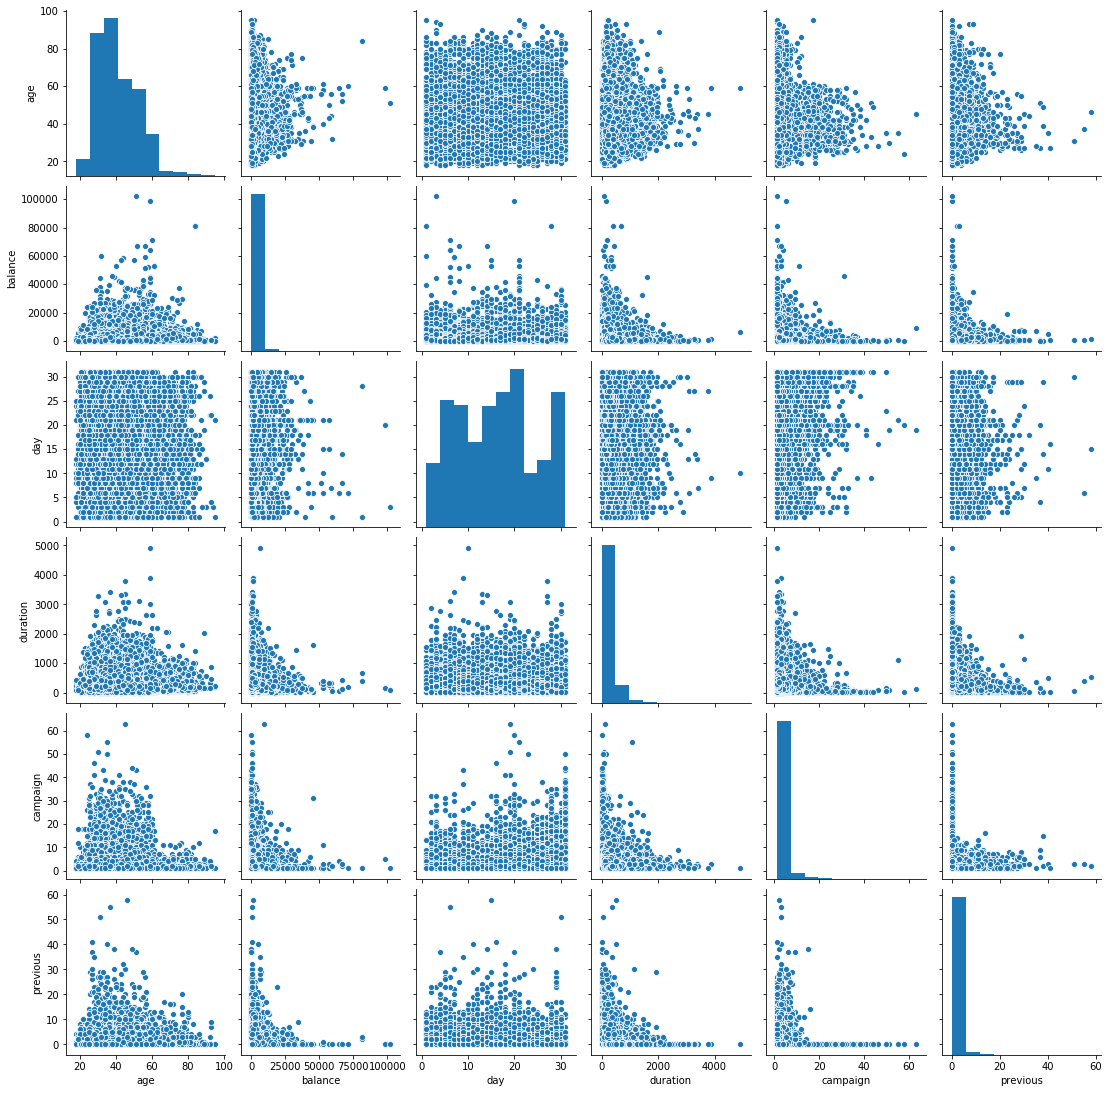

In [16]:
#Multivariate Continuous variables
#Convert Binary features to categorical

cont_mod_bank_df = mod_bank_df.drop(cat_mod_features, axis=1)
sns.pairplot(cont_mod_bank_df)

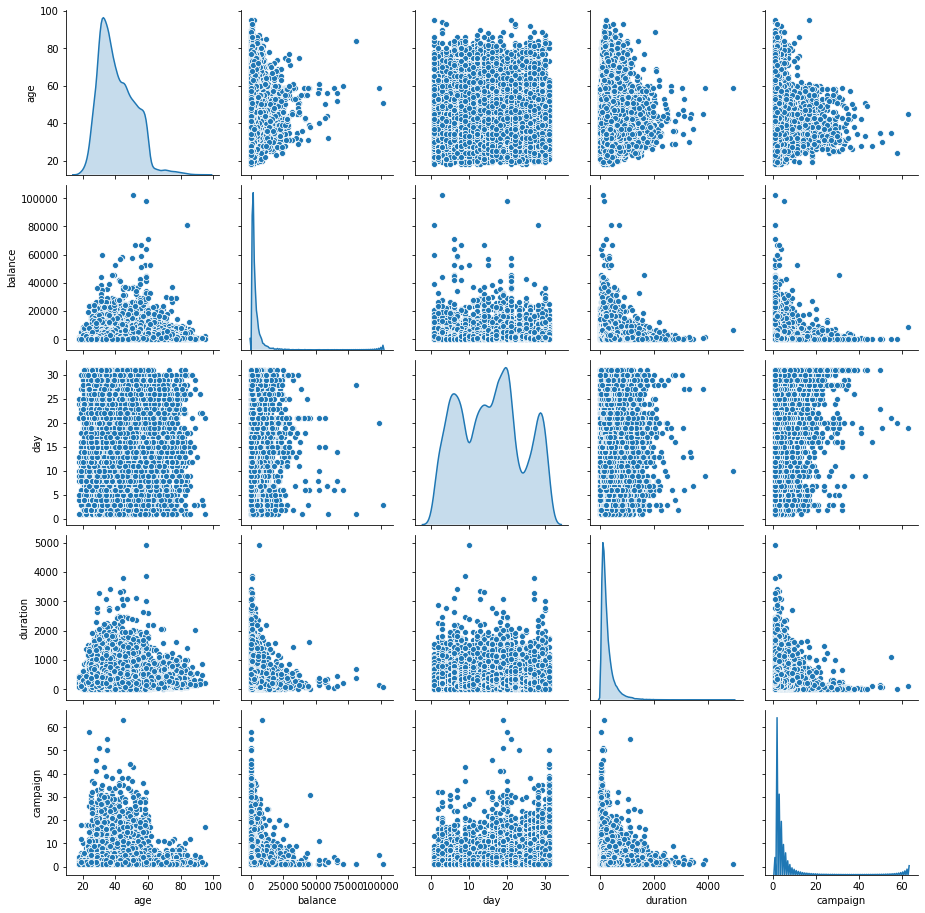

In [17]:
cont_mod_bank_df_norm = cont_mod_bank_df.drop('previous',axis=1)
sns.pairplot(cont_mod_bank_df_norm,diag_kind='kde')

Balance is Inverse with previous, campaign, and duration.
Duration is Inverse with previous.

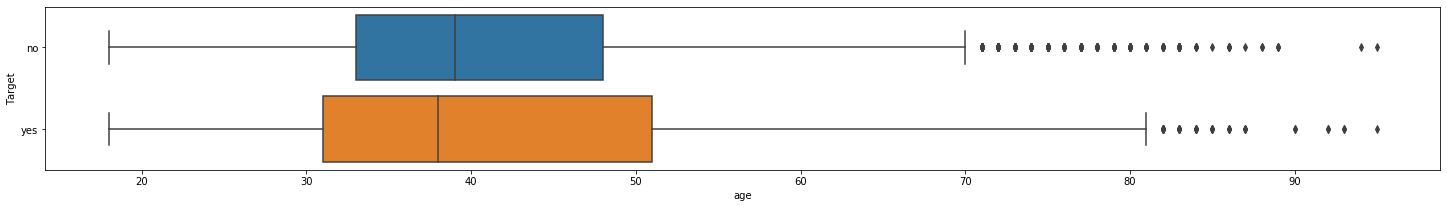

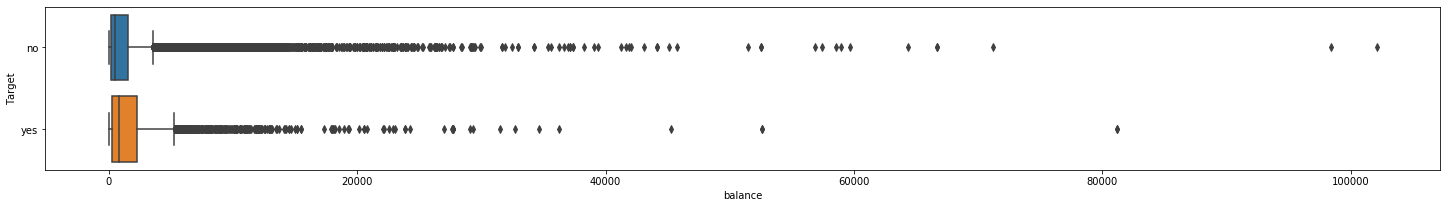

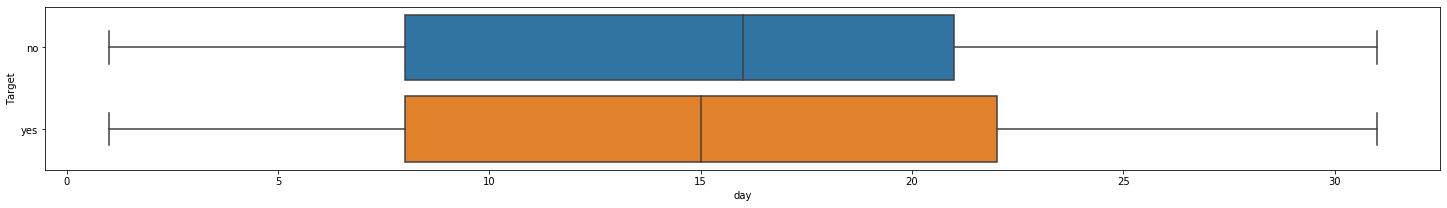

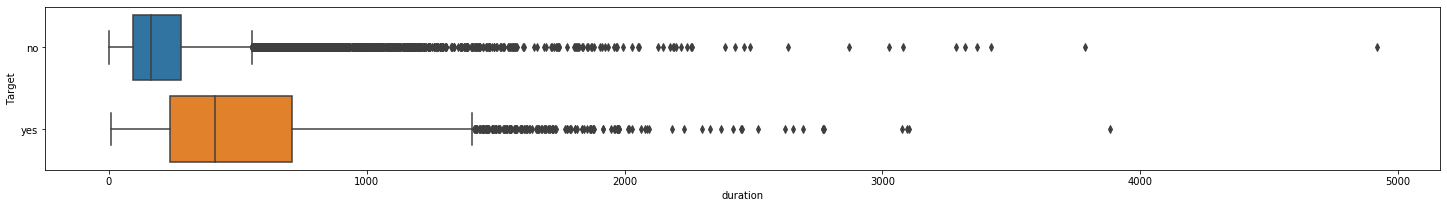

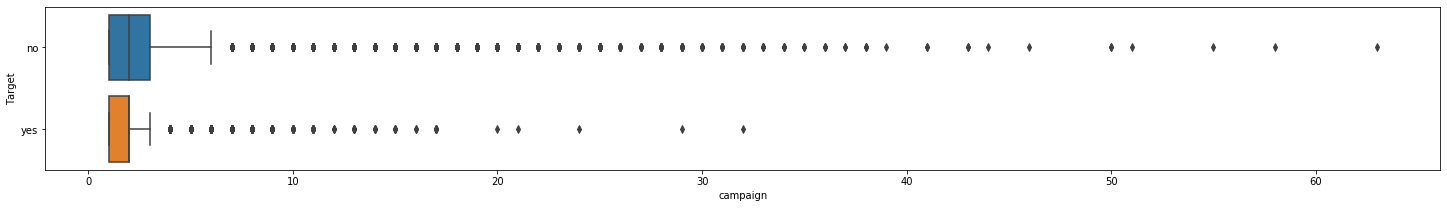

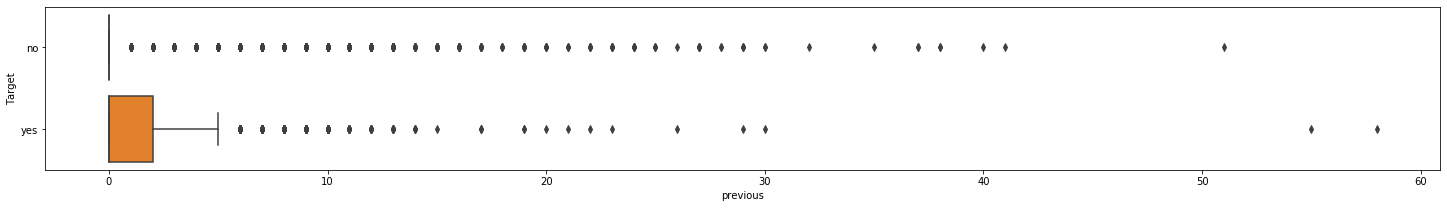

In [18]:
for j in cont_mod_bank_df.columns[:-1]:
    fig, axs = plt.subplots(figsize= (25,3))
    cont_bi_box_plot = sns.boxplot(x=cont_mod_bank_df[j],y=cont_mod_bank_df['Target'])
    plt.show()
#So many outliers that need normalizing

Age and Days show not significant difference in target

In [19]:
#Statistical on continuous variables. Need to split continuous group into two for Yes and No on Target to compare.
from scipy.stats import ttest_ind, ttest_ind_from_stats
for t in cont_mod_bank_df.columns[:-1]:
    group0 = cont_mod_bank_df.loc[cont_mod_bank_df['Target'].str.contains('no')][t]
    group1 = cont_mod_bank_df.loc[cont_mod_bank_df['Target'].str.contains('yes')][t]  
    t_statistic, p_value = ttest_ind(group0, group1)
    print('P-value for',t,'in two group of Target: ', p_value,'\n')

P-value for age in two group of Target:  2.374953503320265e-07 

P-value for balance in two group of Target:  6.050788491655522e-20 

P-value for day in two group of Target:  7.753676438059458e-08 

P-value for duration in two group of Target:  0.0 

P-value for campaign in two group of Target:  1.2278146121832635e-53 

P-value for previous in two group of Target:  1.8675554993305279e-124 



P-Values are Low for all continuous variables, which indicates difference between two 'yes' and 'no' group of each feature. So all of these features can be used for predictions but skewed ones need to be normalized

       age_bucket      balance        day    duration  campaign  previous
0  (17.999, 27.0]  1117.723827  15.764982  277.453791  2.407220  0.587726
1    (27.0, 30.0]  1174.486606  15.813035  269.457885  2.653134  0.572770
2    (30.0, 32.0]  1391.175806  16.182796  258.262366  2.805376  0.584409
3    (32.0, 33.0]  1342.258296  15.784292  257.137721  2.678097  0.695243
4    (33.0, 35.0]  1301.182157  15.841079  258.117326  2.828170  0.724900


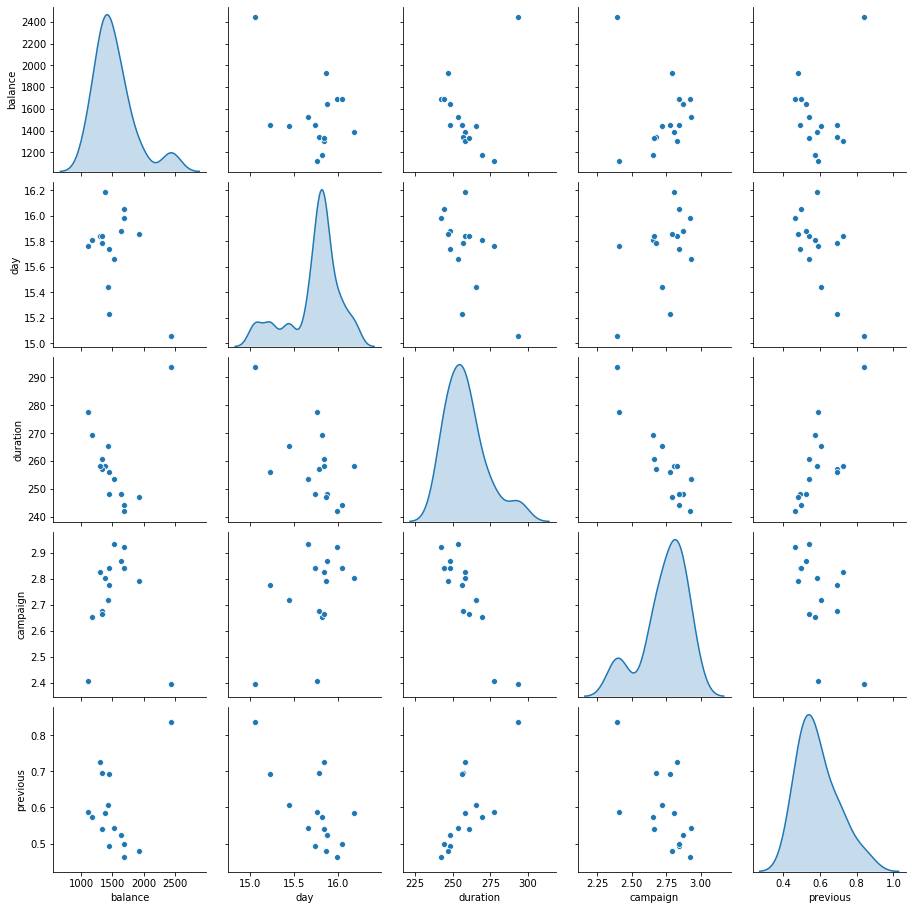

In [20]:
#Bucket Age and check pairplot again
bucket_mod_bank_df = cont_mod_bank_df.drop('Target',axis=1)
bucket_mod_bank_df['age_bucket'] = pd.qcut(bucket_mod_bank_df['age'],q=15)
group_bucket = bucket_mod_bank_df.groupby(by='age_bucket').agg('mean').drop('age',axis=1).reset_index()
print(group_bucket.head())
sns.pairplot(group_bucket,diag_kind='kde')

When pairplot was done again after bucketing age and aggregating mean continuous variables, features are more normalized and correlation between feature is clearer

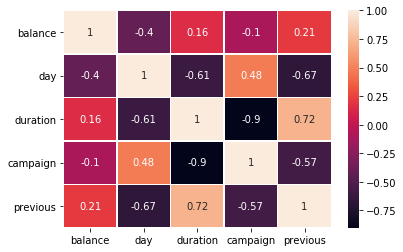

In [21]:
corr = group_bucket.corr()
ax = sns.heatmap(corr, linewidths=.5,annot=True)

campaign vs duration are highly correlated

# Deliverable 2

### Ensure data type is correct

In [22]:
mod_bank_df.Contacted_in_900D = mod_bank_df.Contacted_in_900D.astype(str)
mod_bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41444 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                41444 non-null  int64 
 1   job                41444 non-null  object
 2   marital            41444 non-null  object
 3   education          41444 non-null  object
 4   default            41444 non-null  object
 5   balance            41444 non-null  int64 
 6   housing            41444 non-null  object
 7   loan               41444 non-null  object
 8   contact            41444 non-null  object
 9   day                41444 non-null  int64 
 10  month              41444 non-null  object
 11  duration           41444 non-null  int64 
 12  campaign           41444 non-null  int64 
 13  Contacted_in_900D  41444 non-null  object
 14  previous           41444 non-null  int64 
 15  poutcome           41444 non-null  object
 16  Target             41444 non-null  objec

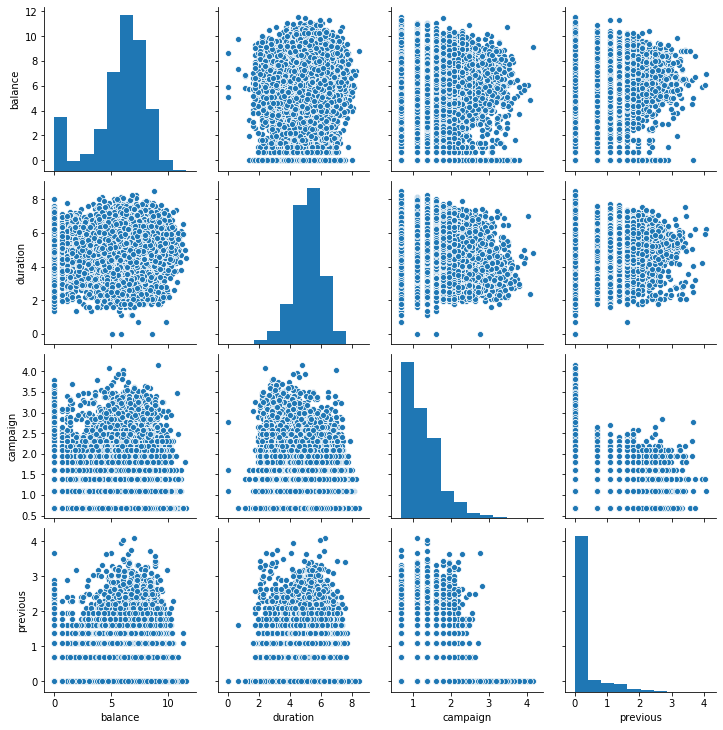

In [23]:
#1) Need to change default, housing, loan, Target values to binary numbers
binary_col = ['default','housing','loan','Target']
bi_mod_bank_df = mod_bank_df.copy()
for col in binary_col:
    bi_mod_bank_df = bi_mod_bank_df.replace({col : { 'no' : '0', 'yes' : '1'}})
    bi_mod_bank_df[col] = bi_mod_bank_df[col].astype(int)
    

#2) Need to change other categorical values with hot encoding or Label Encoding
#Month
mo = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
i = 0
for m in mo:
    i+=1
    bi_mod_bank_df = bi_mod_bank_df.replace({'month' : { m : i}})

#Education
ed = ['primary','secondary','tertiary','unknown']
j = 0
for e in ed:
    j+=1
    bi_mod_bank_df = bi_mod_bank_df.replace({'education' : { e : j}})

#Contacted_in_900D
bi_mod_bank_df['Contacted_in_900D'] = bi_mod_bank_df['Contacted_in_900D'].astype(int)

#Rest are One-Hot Encoded
bi_mod_bank_df = pd.get_dummies(bi_mod_bank_df,drop_first = True)


#3) Normalize skewed continuous variables: balance, duration, campaign, previous and Check pairplot again
sk_col = ['balance','duration','campaign','previous']
for sk in sk_col:
    bi_mod_bank_df[sk] = np.log(bi_mod_bank_df[sk]+1)
cont_bi_mod_bank_df = bi_mod_bank_df[sk_col]
sns.pairplot(cont_bi_mod_bank_df)
#More normalized

In [24]:
#Check data and data type of all features that they are all numbers
print(bi_mod_bank_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41444 entries, 0 to 45210
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                41444 non-null  int64  
 1   education          41444 non-null  int64  
 2   default            41444 non-null  int32  
 3   balance            41444 non-null  float64
 4   housing            41444 non-null  int32  
 5   loan               41444 non-null  int32  
 6   day                41444 non-null  int64  
 7   month              41444 non-null  int64  
 8   duration           41444 non-null  float64
 9   campaign           41444 non-null  float64
 10  Contacted_in_900D  41444 non-null  int32  
 11  previous           41444 non-null  float64
 12  Target             41444 non-null  int32  
 13  job_blue-collar    41444 non-null  uint8  
 14  job_entrepreneur   41444 non-null  uint8  
 15  job_housemaid      41444 non-null  uint8  
 16  job_management     414

In [25]:
#Create Training and Test Set
bank_df_final = bi_mod_bank_df.copy()
seed = 77
X_train, X_test, y_train, y_test = train_test_split(bank_df_final.drop('Target',axis=1)
                                                    , bank_df_final['Target'], test_size=0.30,random_state=seed)

# Deliverable 3

In [26]:
#Logistic Regression (Use multiple hyperparameters for optimal model)
# penalty_ls = []
threshold = []
train_score = []
test_score = []
recall = []
precision = []
f1_value = []
roc_auc = []


C = [0.3, 0.5, 0.7, 0.9]
#Any treshold value did not change much on performace. Choosing 0.5 as threshold.
# solver = ['newton-cg','lbfgs','liblinear','sag','saga']
#Takes too long in double loop. newton-cg gave the best acc, recall, precision, f1
for j in C:
    lr = LogisticRegression(random_state=77, C = j,solver='newton-cg', class_weight = 'balanced')  # changing values of solver
    lr.fit(X_train, y_train) 
    y_predict = lr.predict(X_test)     

    threshold.append(j)


    train_score.append(round(lr.score(X_train, y_train),3))
    test_score.append(round(lr.score(X_test, y_test),3))

    recall.append(recall_score(y_test,y_predict))

    precision.append(precision_score(y_test,y_predict))

    f1_value.append(f1_score(y_test,y_predict))

    roc_auc.append(roc_auc_score(y_test,y_predict))


print('\nShow me Result\n')   

result = pd.DataFrame(list(zip(threshold,train_score,test_score,recall,precision,f1_value,roc_auc)), 
               columns =['threshold', 'train_acc', 'test_acc', 'recall','precision','f1_score','ROC_AUC_score']) 
result['Model'] = 'Logistic'
print(result.head())
#all test results are pretty low


Show me Result

   threshold  train_acc  test_acc    recall  precision  f1_score  \
0        0.3      0.808     0.802  0.807848   0.354198  0.492473   
1        0.5      0.808     0.802  0.807848   0.354408  0.492676   
2        0.7      0.808     0.802  0.807848   0.354303  0.492574   
3        0.9      0.808     0.802  0.807848   0.354198  0.492473   

   ROC_AUC_score     Model  
0       0.804572  Logistic  
1       0.804664  Logistic  
2       0.804618  Logistic  
3       0.804572  Logistic  


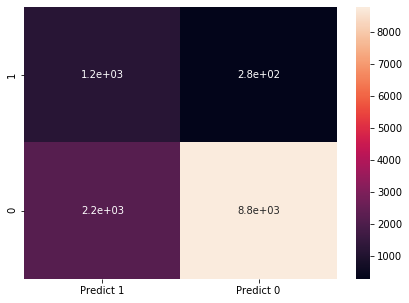

In [27]:
#Logistic Regression Confusion Matrix
cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
#Refer to results above

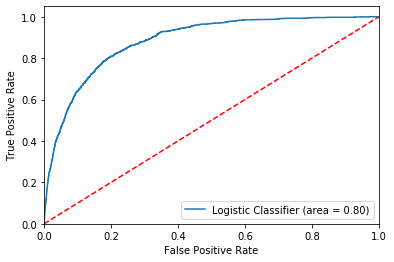

In [28]:
#Logistic ROC AUC Curve
logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
#Refer to results above

In [29]:
logit = sm.Logit( y_train, sm.add_constant( X_train ) )
lg = logit.fit()
lg.summary()

#Checking P-values to make performance better later on

Optimization terminated successfully.
         Current function value: 0.247231
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                29010
Model:                          Logit   Df Residuals:                    28979
Method:                           MLE   Df Model:                           30
Date:                Fri, 09 Oct 2020   Pseudo R-squ.:                  0.3408
Time:                        13:40:05   Log-Likelihood:                -7172.2
converged:                       True   LL-Null:                       -10881.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -12.4979      1.238    -10.095      0.000     -14.924     -10.071
age                   0.0032      0.003      1.245      0.213      -0.002       0.008
education             0.1278      0.034      3.728      0.000       0.061       0.195
default              -0.1437      0.290     -0.495      0.621      -0.713       0.426
balance               0.0677      0.010      6.856      0.000       0.048       0.087
housing              -0.7880      0.048    -16.282      0.000      -0.883      -0.693
loan                 -0.5296      0.074     -7.192      0.000      -0.674      -0.385
day                  -0.0016      0.003     -0.607      0.544      -0.007       0.004
month                -0.0131      0.008     -1.605      0.108      -0.029       0.003
duration              1.7894      0.033     54.018      0.000       1.725       1.854
campaign             -0.4429      0.053     -8.364      0.000      -0.547      -0.339
Contacted_in_900D     0.8141      1.209      0.673      0.501      -1.555       3.184
previous              0.2796      0.076      3.685      0.000       0.131       0.428
job_blue-collar      -0.4382      0.086     -5.109      0.000      -0.606      -0.270
job_entrepreneur     -0.4010      0.151     -2.657      0.008      -0.697      -0.105
job_housemaid        -0.3976      0.156     -2.550      0.011      -0.703      -0.092
job_management       -0.1320      0.081     -1.630      0.103      -0.291       0.027
job_retired           0.2476      0.115      2.153      0.031       0.022       0.473
job_self-employed    -0.3160      0.132     -2.394      0.017      -0.575      -0.057
job_services         -0.3521      0.102     -3.460      0.001      -0.552      -0.153
job_student           0.6654      0.130      5.122      0.000       0.411       0.920
job_technician       -0.1880      0.082     -2.279      0.023      -0.350      -0.026
job_unemployed       -0.1991      0.133     -1.493      0.135      -0.460       0.062
job_unknown          -0.5392      0.272     -1.980      0.048      -1.073      -0.006
marital_married      -0.1944      0.071     -2.727      0.006      -0.334      -0.055
marital_single        0.0631      0.081      0.775      0.439      -0.097       0.223
contact_telephone    -0.1018      0.090     -1.127      0.260      -0.279       0.075
contact_unknown      -1.1245      0.069    -16.322      0.000      -1.260      -0.989
poutcome_other        0.3333      0.108      3.083      0.002       0.121       0.545
poutcome_success      2.3377      0.097     24.072      0.000       2.147       2.528
poutcome_unknown      0.9271      1.205      0.770      0.442      -1.434       3.288
=====================================================================================
"""

In [30]:
##Calculate VIF values
X_values = bank_df_final.values
X_values = np.hstack((np.ones((len(bank_df_final), 1)), X_values))
for index, feature in enumerate(['constant']+bank_df_final.columns.tolist()):
    vif_value = vif(X_values, index)
    print(f"{feature}: {vif_value}", sep="\t")

#Contacted in 900Days and poutcome_unknown have high VIF along with high P-value which can be dropped

constant: 8416.988849168825
age: 1.703651141370713
education: 1.4334712996582464
default: 1.0187226387540187
balance: 1.0383892322397883
housing: 1.2160540733751197
loan: 1.0268239355950193
day: 1.046157515425953
month: 1.0983983403184634
duration: 1.1778448094760132
campaign: 1.0901265840749057
Contacted_in_900D: 1268.307226549543
previous: 5.281078033728414
Target: 1.3069117663321834
job_blue-collar: 2.367796954764675
job_entrepreneur: 1.271256272595327
job_housemaid: 1.2627434749349904
job_management: 2.521106571240886
job_retired: 1.7050739114130449
job_self-employed: 1.2900582924238333
job_services: 1.6328589658497306
job_student: 1.262239982688881
job_technician: 2.090681035149233
job_unemployed: 1.236924014205515
job_unknown: 1.0793529170872815
marital_married: 2.590116105753528
marital_single: 2.950767002896132
contact_telephone: 1.0821088373097527
contact_unknown: 1.2571925285924763
poutcome_other: 1.3384059000556177
poutcome_success: 1.3997011080029769
poutcome_unknown: 1263.

In [31]:
#Compare above Logistic Regression performance to Decision Tree
dt_model = DecisionTreeClassifier(criterion = 'gini',max_depth = 5) #I could probably use for loop for criterion and max_depth but takes too long
dt_model.fit(X_train, y_train)
dt_model.score(X_test , y_test)
dt_y_pred = dt_model.predict(X_test)
print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns))#Print the feature importance of the decision model

                        Imp
age                0.012524
education          0.000000
default            0.000000
balance            0.005311
housing            0.058023
loan               0.000000
day                0.003165
month              0.015244
duration           0.548418
campaign           0.000000
Contacted_in_900D  0.000000
previous           0.000000
job_blue-collar    0.000000
job_entrepreneur   0.000000
job_housemaid      0.000000
job_management     0.000000
job_retired        0.001228
job_self-employed  0.000000
job_services       0.000000
job_student        0.000000
job_technician     0.000000
job_unemployed     0.000000
job_unknown        0.000000
marital_married    0.000000
marital_single     0.000000
contact_telephone  0.000000
contact_unknown    0.045876
poutcome_other     0.000000
poutcome_success   0.310212
poutcome_unknown   0.000000


In [32]:
dt_train_score = round(dt_model.score(X_train, y_train),3)
dt_test_score = round(dt_model.score(X_test, y_test),3)
dt_recall = recall_score(y_test,dt_y_pred)
dt_precision = precision_score(y_test,dt_y_pred)
dt_f1_value = f1_score(y_test,dt_y_pred)
dt_roc_auc = roc_auc_score(y_test,dt_y_pred)

print('\nShow me DT Result\n')   


dt_list = dt_train_score,dt_test_score,dt_recall,dt_precision,dt_f1_value,dt_roc_auc

dt_result = pd.DataFrame((dt_list)).T.rename(columns = {0:'train_acc', 1:'test_acc', 2:'recall',3:'precision'
                                              ,4:'f1_score',5:'ROC_AUC_score'})
dt_result['Model'] = 'Decision_Tree'

dt_concat_1 = pd.concat([result.drop(['threshold'],axis=1),dt_result])

print(dt_concat_1.tail(2).reset_index(drop=True))



Show me DT Result

   train_acc  test_acc    recall  precision  f1_score  ROC_AUC_score  \
0      0.808     0.802  0.807848   0.354198  0.492473       0.804572   
1      0.897     0.899  0.351150   0.640741  0.453671       0.662295   

           Model  
0       Logistic  
1  Decision_Tree  


Decision tree performed better on Precision and accuracy than Logistic while Logistic had highest recall value but we want to maximize Precision as calling 0 target person would waste a lot of worker's time

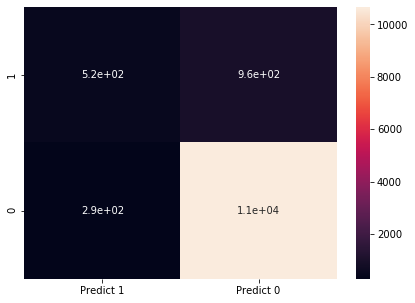

In [33]:
#Decision Tree Confusion Matrix
dt_cm=metrics.confusion_matrix(y_test, dt_y_pred, labels=[1, 0])

dt_df_cm = pd.DataFrame(dt_cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(dt_df_cm, annot=True)
#Refer to results above

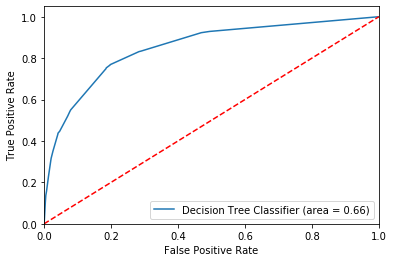

In [34]:
#Decision Tree ROC AUC Curve
logit_roc_auc = roc_auc_score(y_test, dt_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dt_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('DecisionTree_ROC')
plt.show()
#Refer to results above

ROC_AUC curve area within the shape is lower than Logistic Regression

In [35]:
#Bagging and Boosting (G.Boost)
gbcl = GradientBoostingClassifier(n_estimators = 50)
gbcl = gbcl.fit(X_train, y_train)
gbcl.score(X_test , y_test)
gbcl_y_pred = gbcl.predict(X_test)
print (pd.DataFrame(gbcl.feature_importances_, columns = ["Imp"], index = X_train.columns))#Print the feature importance of the boosting model

                        Imp
age                0.037262
education          0.002053
default            0.000000
balance            0.005473
housing            0.054233
loan               0.003367
day                0.008835
month              0.054038
duration           0.509348
campaign           0.004313
Contacted_in_900D  0.000948
previous           0.015117
job_blue-collar    0.001800
job_entrepreneur   0.000000
job_housemaid      0.000566
job_management     0.000724
job_retired        0.000000
job_self-employed  0.000000
job_services       0.000184
job_student        0.008309
job_technician     0.000000
job_unemployed     0.000000
job_unknown        0.000193
marital_married    0.003443
marital_single     0.000000
contact_telephone  0.000950
contact_unknown    0.060950
poutcome_other     0.000476
poutcome_success   0.226722
poutcome_unknown   0.000696


In [36]:
gbcl_train_score = round(gbcl.score(X_train, y_train),3)
gbcl_test_score = round(gbcl.score(X_test, y_test),3)
gbcl_recall = recall_score(y_test,gbcl_y_pred)
gbcl_precision = precision_score(y_test,gbcl_y_pred)
gbcl_f1_value = f1_score(y_test,gbcl_y_pred)
gbcl_roc_auc = roc_auc_score(y_test,gbcl_y_pred)

print('\nShow me G.Boosting Result\n')   

gbcl_list = gbcl_train_score,gbcl_test_score,gbcl_recall,gbcl_precision,gbcl_f1_value,gbcl_roc_auc

gbcl_result = pd.DataFrame((gbcl_list)).T.rename(columns = {0:'train_acc', 1:'test_acc', 2:'recall',3:'precision'
                                              ,4:'f1_score',5:'ROC_AUC_score'})
gbcl_result['Model'] = 'G_Boost'

gbcl_concat = pd.concat([result.drop(['threshold'],axis=1),dt_result,gbcl_result])

print(gbcl_concat.tail(3).reset_index(drop=True))



Show me G.Boosting Result

   train_acc  test_acc    recall  precision  f1_score  ROC_AUC_score  \
0      0.808     0.802  0.807848   0.354198  0.492473       0.804572   
1      0.897     0.899  0.351150   0.640741  0.453671       0.662295   
2      0.900     0.901  0.359269   0.656366  0.464364       0.666948   

           Model  
0       Logistic  
1  Decision_Tree  
2        G_Boost  


G_Boosting is slightly better than Logistic and Decision Tree in all metrics but not significantly

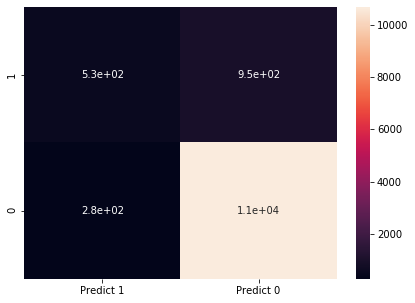

In [37]:
#G. Boost Confusion Matrix
gbcl_cm=metrics.confusion_matrix(y_test, gbcl_y_pred, labels=[1, 0])

gbcl_df_cm = pd.DataFrame(gbcl_cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(gbcl_df_cm, annot=True)
#Refer to results above

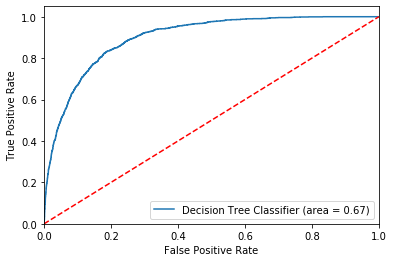

In [38]:
#G.Boost ROC AUC Curve
logit_roc_auc = roc_auc_score(y_test, gbcl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gbcl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('DecisionTree_ROC')
plt.show()
#Refer to results above

In [39]:
#Bagging and Boosting (RF.Classifier)
rfcl = RandomForestClassifier(n_estimators = 50, random_state=1,max_features=20)
rfcl = rfcl.fit(X_train, y_train)
rfcl.score(X_test , y_test)
rfcl_y_pred = rfcl.predict(X_test)
print (pd.DataFrame(rfcl.feature_importances_, columns = ["Imp"], index = X_train.columns))#Print the feature importance of the boosting model

                        Imp
age                0.099016
education          0.024527
default            0.000984
balance            0.111960
housing            0.025641
loan               0.007770
day                0.096879
month              0.082693
duration           0.282023
campaign           0.035390
Contacted_in_900D  0.008064
previous           0.023277
job_blue-collar    0.008144
job_entrepreneur   0.003182
job_housemaid      0.003531
job_management     0.010278
job_retired        0.003818
job_self-employed  0.004901
job_services       0.006111
job_student        0.005630
job_technician     0.011164
job_unemployed     0.004433
job_unknown        0.001380
marital_married    0.011180
marital_single     0.008905
contact_telephone  0.007092
contact_unknown    0.016716
poutcome_other     0.003909
poutcome_success   0.085316
poutcome_unknown   0.006086


In [40]:
rfcl_train_score = round(rfcl.score(X_train, y_train),3)
rfcl_test_score = round(rfcl.score(X_test, y_test),3)
rfcl_recall = recall_score(y_test,rfcl_y_pred)
rfcl_precision = precision_score(y_test,rfcl_y_pred)
rfcl_f1_value = f1_score(y_test,rfcl_y_pred)
rfcl_roc_auc = roc_auc_score(y_test,rfcl_y_pred)

print('\nShow me RF.Classifier Result\n')   

rfcl_list = rfcl_train_score,rfcl_test_score,rfcl_recall,rfcl_precision,rfcl_f1_value,rfcl_roc_auc

rfcl_result = pd.DataFrame((rfcl_list)).T.rename(columns = {0:'train_acc', 1:'test_acc', 2:'recall',3:'precision'
                                              ,4:'f1_score',5:'ROC_AUC_score'})
rfcl_result['Model'] = 'RF_Classifier'

rfcl_concat = pd.concat([result.drop(['threshold'],axis=1),dt_result,gbcl_result, rfcl_result])

print(rfcl_concat.tail(4).reset_index(drop=True))



Show me RF.Classifier Result

   train_acc  test_acc    recall  precision  f1_score  ROC_AUC_score  \
0      0.808     0.802  0.807848   0.354198  0.492473       0.804572   
1      0.897     0.899  0.351150   0.640741  0.453671       0.662295   
2      0.900     0.901  0.359269   0.656366  0.464364       0.666948   
3      1.000     0.903  0.468877   0.621525  0.534516       0.715180   

           Model  
0       Logistic  
1  Decision_Tree  
2        G_Boost  
3  RF_Classifier  


RF_Classifier performed better in all metrics except in precision score with potential overfitting. 

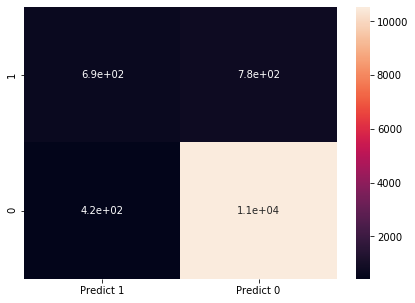

In [41]:
#RF. Classifier Confusion Matrix
rfcl_cm=metrics.confusion_matrix(y_test, rfcl_y_pred, labels=[1, 0])

rfcl_df_cm = pd.DataFrame(rfcl_cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(rfcl_df_cm, annot=True)
#Refer to results above

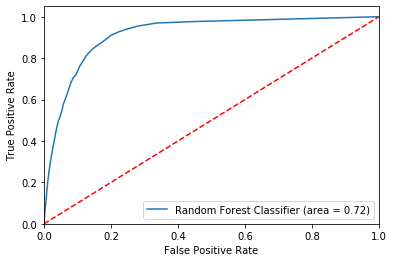

In [42]:
#RF Classifier ROC AUC Curve
logit_roc_auc = roc_auc_score(y_test, rfcl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfcl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Random Forest_ROC')
plt.show()
#Refer to results above

In [43]:
#Bagging and Boosting (Bagging Classifier)
bgcl = BaggingClassifier(n_estimators=10, max_samples= .7, bootstrap=True)
bgcl = bgcl.fit(X_train, y_train)
bgcl.score(X_test , y_test)
bgcl_y_pred = bgcl.predict(X_test)


In [44]:
bgcl_train_score = round(bgcl.score(X_train, y_train),3)
bgcl_test_score = round(bgcl.score(X_test, y_test),3)
bgcl_recall = recall_score(y_test,bgcl_y_pred)
bgcl_precision = precision_score(y_test,bgcl_y_pred)
bgcl_f1_value = f1_score(y_test,bgcl_y_pred)
bgcl_roc_auc = roc_auc_score(y_test,bgcl_y_pred)

print('\nShow me BG.Classifier Result\n')   

bgcl_list = bgcl_train_score,bgcl_test_score,bgcl_recall,bgcl_precision,bgcl_f1_value,bgcl_roc_auc

bgcl_result = pd.DataFrame((bgcl_list)).T.rename(columns = {0:'train_acc', 1:'test_acc', 2:'recall',3:'precision'
                                              ,4:'f1_score',5:'ROC_AUC_score'})
bgcl_result['Model'] = 'BG_Classifier'

bgcl_concat = pd.concat([result.drop(['threshold'],axis=1),dt_result,gbcl_result, rfcl_result,bgcl_result])

print(bgcl_concat.tail(5).reset_index(drop=True))



Show me BG.Classifier Result

   train_acc  test_acc    recall  precision  f1_score  ROC_AUC_score  \
0      0.808     0.802  0.807848   0.354198  0.492473       0.804572   
1      0.897     0.899  0.351150   0.640741  0.453671       0.662295   
2      0.900     0.901  0.359269   0.656366  0.464364       0.666948   
3      1.000     0.903  0.468877   0.621525  0.534516       0.715180   
4      0.978     0.897  0.388363   0.604211  0.472817       0.677022   

           Model  
0       Logistic  
1  Decision_Tree  
2        G_Boost  
3  RF_Classifier  
4  BG_Classifier  


BG Classifier peformed slightly worse than RF_Classifier in all metrics

In [45]:
#Bagging and Boosting (ADA Boosting)
abcl = AdaBoostClassifier(base_estimator=dt_model, n_estimators=50)
# abcl = AdaBoostClassifier( n_estimators= 20)
abcl = abcl.fit(X_train, y_train)
abcl.score(X_test , y_test)
abcl_y_pred = abcl.predict(X_test)

In [46]:
abcl_train_score = round(abcl.score(X_train, y_train),3)
abcl_test_score = round(abcl.score(X_test, y_test),3)
abcl_recall = recall_score(y_test,abcl_y_pred)
abcl_precision = precision_score(y_test,abcl_y_pred)
abcl_f1_value = f1_score(y_test,abcl_y_pred)
abcl_roc_auc = roc_auc_score(y_test,abcl_y_pred)

print('\nShow me ADABoosting Result\n')   

abcl_list = abcl_train_score,abcl_test_score,abcl_recall,abcl_precision,abcl_f1_value,abcl_roc_auc

abcl_result = pd.DataFrame((abcl_list)).T.rename(columns = {0:'train_acc', 1:'test_acc', 2:'recall',3:'precision'
                                              ,4:'f1_score',5:'ROC_AUC_score'})
abcl_result['Model'] = 'ADA_Boosting'

abcl_concat = pd.concat([result.drop(['threshold'],axis=1),dt_result,gbcl_result, rfcl_result,bgcl_result,abcl_result])

print(abcl_concat.tail(6).reset_index(drop=True))



Show me ADABoosting Result

   train_acc  test_acc    recall  precision  f1_score  ROC_AUC_score  \
0      0.808     0.802  0.807848   0.354198  0.492473       0.804572   
1      0.897     0.899  0.351150   0.640741  0.453671       0.662295   
2      0.900     0.901  0.359269   0.656366  0.464364       0.666948   
3      1.000     0.903  0.468877   0.621525  0.534516       0.715180   
4      0.978     0.897  0.388363   0.604211  0.472817       0.677022   
5      0.946     0.893  0.468877   0.562044  0.511250       0.709794   

           Model  
0       Logistic  
1  Decision_Tree  
2        G_Boost  
3  RF_Classifier  
4  BG_Classifier  
5   ADA_Boosting  


Ada boost with Decision tree model base shows slightly better in recall than RF.classifier but lower in other metrics

#### Please refer to above table for Metric Dataframe. The best algorith is Random Forest out of other Classifier models. Random forest consist of bagging + generating trees using random columns, which is more diverse forest. Also this model is more strong with overfit data since eventually overfitting will be corrected

#### Random Forest had highest f1_score along with best precision to recall ratio + best test accuracy with possible training model overfitting

#### Extra testing

In [47]:
#SVM
svmcl = svm.SVC()
svmcl = abcl.fit(X_train, y_train)
svmcl.score(X_test , y_test)
svmcl_y_pred = svmcl.predict(X_test)

In [48]:
svmcl_train_score = round(svmcl.score(X_train, y_train),3)
svmcl_test_score = round(svmcl.score(X_test, y_test),3)
svmcl_recall = recall_score(y_test,svmcl_y_pred)
svmcl_precision = precision_score(y_test,svmcl_y_pred)
svmcl_f1_value = f1_score(y_test,svmcl_y_pred)
svmcl_roc_auc = roc_auc_score(y_test,svmcl_y_pred)

print('\nShow me ADABoosting Result\n')   

svmcl_list = svmcl_train_score,svmcl_test_score,svmcl_recall,svmcl_precision,svmcl_f1_value,svmcl_roc_auc

svmcl_result = pd.DataFrame((svmcl_list)).T.rename(columns = {0:'train_acc', 1:'test_acc', 2:'recall',3:'precision'
                                              ,4:'f1_score',5:'ROC_AUC_score'})
svmcl_result['Model'] = 'SVM'

svmcl_concat = pd.concat([result.drop(['threshold'],axis=1),dt_result,gbcl_result, rfcl_result
                          ,bgcl_result,abcl_result,svmcl_result])

print(svmcl_concat.tail(8).reset_index(drop=True))



Show me ADABoosting Result

   train_acc  test_acc    recall  precision  f1_score  ROC_AUC_score  \
0      0.808     0.802  0.807848   0.354303  0.492574       0.804618   
1      0.808     0.802  0.807848   0.354198  0.492473       0.804572   
2      0.897     0.899  0.351150   0.640741  0.453671       0.662295   
3      0.900     0.901  0.359269   0.656366  0.464364       0.666948   
4      1.000     0.903  0.468877   0.621525  0.534516       0.715180   
5      0.978     0.897  0.388363   0.604211  0.472817       0.677022   
6      0.946     0.893  0.468877   0.562044  0.511250       0.709794   
7      0.947     0.892  0.465494   0.554392  0.506068       0.707510   

           Model  
0       Logistic  
1       Logistic  
2  Decision_Tree  
3        G_Boost  
4  RF_Classifier  
5  BG_Classifier  
6   ADA_Boosting  
7            SVM  


### Removing Features and Test Model

In [49]:
bank_df_final_rev = bank_df_final.copy()
# 1) Remove highly correlated features due to independence assumption of features
# Highly correlated features are shown above heat map output 20, Output21. Campaign and Duration.
bank_df_final_rev_remove1 = bank_df_final_rev.drop(['campaign','duration'],axis=1)

In [50]:
#Create Training and Test Set
seed = 77
X_train, X_test, y_train, y_test = train_test_split(bank_df_final_rev_remove1.drop('Target',axis=1)
                                                    , bank_df_final_rev_remove1['Target'], test_size=0.30,random_state=seed)


Show me Result

   threshold  train_acc  test_acc    recall  precision  f1_score  \
0        0.3      0.699     0.699  0.656969   0.230971  0.341781   
1        0.5      0.700     0.699  0.656969   0.231025  0.341841   
2        0.7      0.700     0.700  0.657645   0.231318  0.342254   
3        0.9      0.700     0.699  0.657645   0.231153  0.342073   

   ROC_AUC_score     Model  
0       0.680940  Logistic  
1       0.680985  Logistic  
2       0.681415  Logistic  
3       0.681278  Logistic  


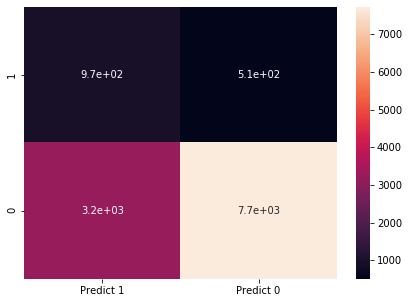

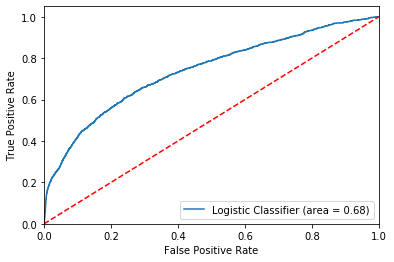

In [51]:
#Logistic Regression (Use multiple hyperparameters for optimal model)
# penalty_ls = []
threshold = []
train_score = []
test_score = []
recall = []
precision = []
f1_value = []
roc_auc = []


C = [0.3, 0.5, 0.7, 0.9]
#Any treshold value did not change much on performace. Choosing 0.5 as threshold.
# solver = ['newton-cg','lbfgs','liblinear','sag','saga']
#Takes too long in double loop. newton-cg gave the best acc, recall, precision, f1
for j in C:
    lr = LogisticRegression(random_state=77, C = j,class_weight = 'balanced', solver = 'newton-cg')  # changing values of solver
    lr.fit(X_train, y_train) 
    y_predict = lr.predict(X_test)     

    threshold.append(j)


    train_score.append(round(lr.score(X_train, y_train),3))
    test_score.append(round(lr.score(X_test, y_test),3))

    recall.append(recall_score(y_test,y_predict))

    precision.append(precision_score(y_test,y_predict))

    f1_value.append(f1_score(y_test,y_predict))

    roc_auc.append(roc_auc_score(y_test,y_predict))


print('\nShow me Result\n')   

result = pd.DataFrame(list(zip(threshold,train_score,test_score,recall,precision,f1_value,roc_auc)), 
               columns =['threshold', 'train_acc', 'test_acc', 'recall','precision','f1_score','ROC_AUC_score']) 
result['Model'] = 'Logistic'
print(result.head())



#Logistic Regression Confusion Matrix
cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
#Refer to results above


#Logistic ROC AUC Curve
logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
#Refer to results above




Precision is toooo low and accuracy drops after removing the feature

In [52]:
bank_df_final_rev = bank_df_final.copy()
# 1) Remove high p-value features due to independence assumption of features
# High p-values can be found in above Logistic Summary

bank_df_final_rev_remove2 = bank_df_final_rev.drop(['day','Contacted_in_900D','marital_single','poutcome_unknown'],axis=1)

In [53]:
#Create Training and Test Set
seed = 77
X_train, X_test, y_train, y_test = train_test_split(bank_df_final_rev_remove2.drop('Target',axis=1)
                                                    , bank_df_final_rev_remove2['Target'], test_size=0.30,random_state=seed)


Show me Result

   threshold  train_acc  test_acc    recall  precision  f1_score  \
0        0.3      0.895     0.898  0.324763   0.638298  0.430493   
1        0.5      0.894     0.898  0.327470   0.639366  0.433110   
2        0.7      0.894     0.898  0.327470   0.639366  0.433110   
3        0.9      0.894     0.898  0.327470   0.638522  0.432916   

   ROC_AUC_score     Model  
0       0.649968  Logistic  
1       0.651276  Logistic  
2       0.651276  Logistic  
3       0.651230  Logistic  


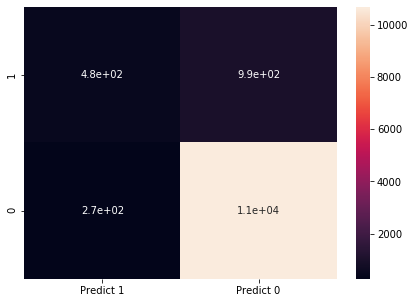

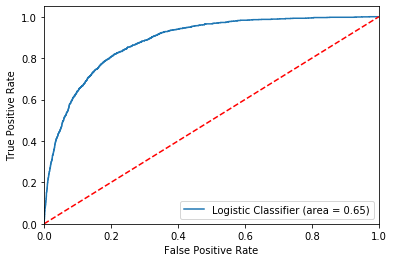

In [54]:
#Logistic Regression (Use multiple hyperparameters for optimal model) WITHOUT BALANCED class_weight
# penalty_ls = []
threshold = []
train_score = []
test_score = []
recall = []
precision = []
f1_value = []
roc_auc = []


C = [0.3, 0.5, 0.7, 0.9]
#Any treshold value did not change much on performace. Choosing 0.5 as threshold.
# solver = ['newton-cg','lbfgs','liblinear','sag','saga']
#Takes too long in double loop. newton-cg gave the best acc, recall, precision, f1
for j in C:
    lr = LogisticRegression(random_state=77, C = j, solver = 'newton-cg')  # changing values of solver
    lr.fit(X_train, y_train) 
    y_predict = lr.predict(X_test)     

    threshold.append(j)


    train_score.append(round(lr.score(X_train, y_train),3))
    test_score.append(round(lr.score(X_test, y_test),3))

    recall.append(recall_score(y_test,y_predict))

    precision.append(precision_score(y_test,y_predict))

    f1_value.append(f1_score(y_test,y_predict))

    roc_auc.append(roc_auc_score(y_test,y_predict))


print('\nShow me Result\n')   

result = pd.DataFrame(list(zip(threshold,train_score,test_score,recall,precision,f1_value,roc_auc)), 
               columns =['threshold', 'train_acc', 'test_acc', 'recall','precision','f1_score','ROC_AUC_score']) 
result['Model'] = 'Logistic'
print(result.head())



#Logistic Regression Confusion Matrix
cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
#Refer to results above


#Logistic ROC AUC Curve
logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
#Refer to results above




Random Forest is still better

In [55]:
logit = sm.Logit( y_train, sm.add_constant( X_train ) )
lg = logit.fit()
lg.summary()

#Checking P-values to make performance better later on

Optimization terminated successfully.
         Current function value: 0.247272
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                29010
Model:                          Logit   Df Residuals:                    28983
Method:                           MLE   Df Model:                           26
Date:                Fri, 09 Oct 2020   Pseudo R-squ.:                  0.3407
Time:                        13:40:42   Log-Likelihood:                -7173.4
converged:                       True   LL-Null:                       -10881.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -11.5369      0.251    -46.009      0.000     -12.028     -11.045
age                   0.0025      0.002      1.027      0.304      -0.002       0.007
education             0.1281      0.034      3.738      0.000       0.061       0.195
default              -0.1490      0.291     -0.513      0.608      -0.718       0.420
balance               0.0678      0.010      6.883      0.000       0.048       0.087
housing              -0.7944      0.048    -16.499      0.000      -0.889      -0.700
loan                 -0.5297      0.074     -7.198      0.000      -0.674      -0.385
month                -0.0130      0.008     -1.593      0.111      -0.029       0.003
duration              1.7904      0.033     54.069      0.000       1.725       1.855
campaign             -0.4416      0.052     -8.420      0.000      -0.544      -0.339
previous              0.2228      0.044      5.026      0.000       0.136       0.310
job_blue-collar      -0.4378      0.086     -5.106      0.000      -0.606      -0.270
job_entrepreneur     -0.4029      0.151     -2.670      0.008      -0.699      -0.107
job_housemaid        -0.3993      0.156     -2.559      0.010      -0.705      -0.094
job_management       -0.1305      0.081     -1.612      0.107      -0.289       0.028
job_retired           0.2518      0.115      2.195      0.028       0.027       0.477
job_self-employed    -0.3147      0.132     -2.385      0.017      -0.573      -0.056
job_services         -0.3537      0.102     -3.477      0.001      -0.553      -0.154
job_student           0.6717      0.130      5.185      0.000       0.418       0.926
job_technician       -0.1870      0.082     -2.269      0.023      -0.349      -0.025
job_unemployed       -0.1975      0.133     -1.482      0.138      -0.459       0.064
job_unknown          -0.5342      0.272     -1.962      0.050      -1.068      -0.001
marital_married      -0.2352      0.047     -4.968      0.000      -0.328      -0.142
contact_telephone    -0.0955      0.090     -1.060      0.289      -0.272       0.081
contact_unknown      -1.1159      0.068    -16.319      0.000      -1.250      -0.982
poutcome_other        0.3046      0.105      2.907      0.004       0.099       0.510
poutcome_success      2.3063      0.092     25.177      0.000       2.127       2.486
=====================================================================================
"""

In [56]:
#Remove high Coefficient features. Continuation above 2nd removal feature data.
bank_df_final_rev_remove3 = bank_df_final_rev_remove2.drop(['poutcome_success','duration'],axis=1)

In [57]:
#Create Training and Test Set
seed = 77
X_train, X_test, y_train, y_test = train_test_split(bank_df_final_rev_remove3.drop('Target',axis=1)
                                                    , bank_df_final_rev_remove3['Target'], test_size=0.30,random_state=seed)


Show me Result

   threshold  train_acc  test_acc    recall  precision  f1_score  \
0        0.3      0.877     0.881  0.026387   0.506494  0.050161   
1        0.5      0.877     0.881  0.027064   0.500000  0.051348   
2        0.7      0.877     0.881  0.027064   0.500000  0.051348   
3        0.9      0.877     0.881  0.027064   0.500000  0.051348   

   ROC_AUC_score     Model  
0       0.511459  Logistic  
1       0.511706  Logistic  
2       0.511706  Logistic  
3       0.511706  Logistic  


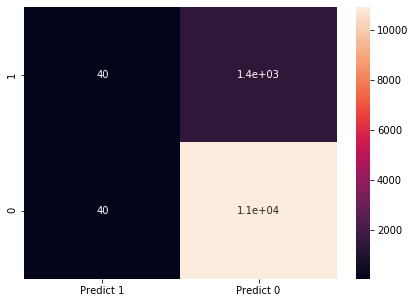

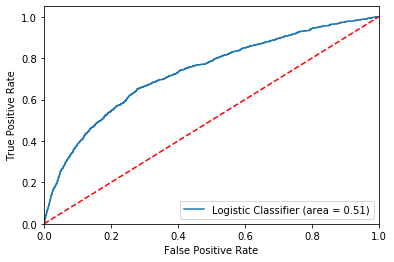

In [58]:
#Logistic Regression (Use multiple hyperparameters for optimal model) WITHOUT BALANCED class_weight
# penalty_ls = []
threshold = []
train_score = []
test_score = []
recall = []
precision = []
f1_value = []
roc_auc = []


C = [0.3, 0.5, 0.7, 0.9]
#Any treshold value did not change much on performace. Choosing 0.5 as threshold.
# solver = ['newton-cg','lbfgs','liblinear','sag','saga']
#Takes too long in double loop. newton-cg gave the best acc, recall, precision, f1
for j in C:
    lr = LogisticRegression(random_state=77, C = j, solver = 'newton-cg')  # changing values of solver
    lr.fit(X_train, y_train) 
    y_predict = lr.predict(X_test)     

    threshold.append(j)


    train_score.append(round(lr.score(X_train, y_train),3))
    test_score.append(round(lr.score(X_test, y_test),3))

    recall.append(recall_score(y_test,y_predict))

    precision.append(precision_score(y_test,y_predict))

    f1_value.append(f1_score(y_test,y_predict))

    roc_auc.append(roc_auc_score(y_test,y_predict))


print('\nShow me Result\n')   

result = pd.DataFrame(list(zip(threshold,train_score,test_score,recall,precision,f1_value,roc_auc)), 
               columns =['threshold', 'train_acc', 'test_acc', 'recall','precision','f1_score','ROC_AUC_score']) 
result['Model'] = 'Logistic'
print(result.head())



#Logistic Regression Confusion Matrix
cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
#Refer to results above


#Logistic ROC AUC Curve
logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
#Refer to results above




Removing further more features made model worse

In [59]:
#Try Random Forest the best model above with feature removal using 2nd removal Dataset bank_df_final_rev_remove2
#Create Training and Test Set
seed = 77
X_train, X_test, y_train, y_test = train_test_split(bank_df_final_rev_remove2.drop('Target',axis=1)
                                                    , bank_df_final_rev_remove2['Target'], test_size=0.30,random_state=seed)


                        Imp
age                0.116131
education          0.027675
default            0.001009
balance            0.137390
housing            0.025973
loan               0.009344
month              0.093730
duration           0.302208
campaign           0.042058
previous           0.035162
job_blue-collar    0.008990
job_entrepreneur   0.003466
job_housemaid      0.004053
job_management     0.012111
job_retired        0.004020
job_self-employed  0.005279
job_services       0.007743
job_student        0.006346
job_technician     0.012204
job_unemployed     0.004661
job_unknown        0.001648
marital_married    0.015192
contact_telephone  0.008221
contact_unknown    0.017910
poutcome_other     0.005498
poutcome_success   0.091980

Show me RF.Classifier Result

   train_acc  test_acc    recall  precision  f1_score  ROC_AUC_score  \
0      0.877     0.881  0.027064   0.500000  0.051348       0.511706   
1      0.897     0.899  0.351150   0.640741  0.453671       0.662295 

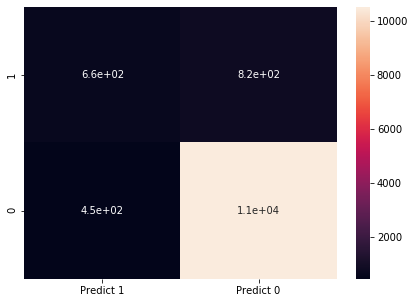

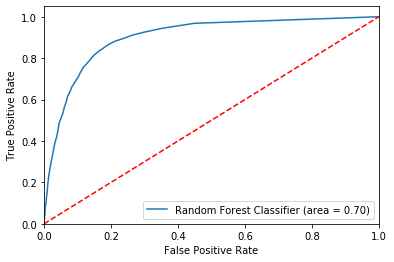

In [60]:
#Bagging and Boosting (RF.Classifier)
rfcl = RandomForestClassifier(n_estimators = 50, random_state=1,max_features=20)
rfcl = rfcl.fit(X_train, y_train)
rfcl.score(X_test , y_test)
rfcl_y_pred = rfcl.predict(X_test)
print (pd.DataFrame(rfcl.feature_importances_, columns = ["Imp"], index = X_train.columns))#Print the feature importance of the boosting model



rfcl_train_score = round(rfcl.score(X_train, y_train),3)
rfcl_test_score = round(rfcl.score(X_test, y_test),3)
rfcl_recall = recall_score(y_test,rfcl_y_pred)
rfcl_precision = precision_score(y_test,rfcl_y_pred)
rfcl_f1_value = f1_score(y_test,rfcl_y_pred)
rfcl_roc_auc = roc_auc_score(y_test,rfcl_y_pred)

print('\nShow me RF.Classifier Result\n')   

rfcl_list = rfcl_train_score,rfcl_test_score,rfcl_recall,rfcl_precision,rfcl_f1_value,rfcl_roc_auc

rfcl_result = pd.DataFrame((rfcl_list)).T.rename(columns = {0:'train_acc', 1:'test_acc', 2:'recall',3:'precision'
                                              ,4:'f1_score',5:'ROC_AUC_score'})
rfcl_result['Model'] = 'RF_Classifier'

rfcl_concat = pd.concat([result.drop(['threshold'],axis=1),dt_result,gbcl_result, rfcl_result])

print(rfcl_concat.tail(4).reset_index(drop=True))




#RF. Classifier Confusion Matrix
rfcl_cm=metrics.confusion_matrix(y_test, rfcl_y_pred, labels=[1, 0])

rfcl_df_cm = pd.DataFrame(rfcl_cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(rfcl_df_cm, annot=True)
#Refer to results above




#RF Classifier ROC AUC Curve
logit_roc_auc = roc_auc_score(y_test, rfcl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfcl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Random Forest_ROC')
plt.show()
#Refer to results above

# Please refer to output 46 for final answer, as further feature engineering didn't improve model